# Часть 1. Реализация [kNN](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B9%D1%88%D0%B8%D1%85_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9) с помощью NumPy

Перед выполнением скачаем файлы `dataset.py` и `download_data.sh`.

In [ ]:
%%bash
gdown 1851TuXmUlNhV3rwmAUCvIGfl6PGJ81RT
gdown 1Of4J41uKxaRPFwyqhgtx_KfhTPH_4LkR

Downloading...
From: https://drive.google.com/uc?id=1851TuXmUlNhV3rwmAUCvIGfl6PGJ81RT
To: /content/dataset.py
100%|██████████| 2.18k/2.18k [00:00<00:00, 2.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Of4J41uKxaRPFwyqhgtx_KfhTPH_4LkR
To: /content/download_data.sh
100%|██████████| 136/136 [00:00<00:00, 149kB/s]


- запустите файл `download_data.sh`, чтобы скачать в директорию data данные, которые мы будем использовать для тренировки (data появится во время запуска bash-скрипта)

In [ ]:
%%bash
bash download_data.sh

--2022-11-13 19:58:42--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

     0K .......... .......... .......... .......... ..........  0%  345K 8m36s
    50K .......... .......... .......... .......... ..........  0%  511K 7m12s
   100K .......... .......... .......... .......... ..........  0% 1016K 5m46s
   150K .......... .......... .......... .......... ..........  0%  515K 5m46s
   200K .......... .......... .......... .......... ..........  0% 1.02M 5m11s
   250K .......... .......... .......... .......... ..........  0% 1014K 4m48s
   300K .......... .......... .......... .......... ..........  0% 1.01M 4m31s
   350K .......... .......... .......... .......... ..........  0% 1.01M 4m19s
   400K .......... ...

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import load_svhn

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Загрузка и визуализация данных

Напишем функцию `load_svhn`, которая загружает данные с диска и возвращает данные для тренировки и тестирования в виде numpy arrays. Мы используем цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/) для обучения модели.

In [ ]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

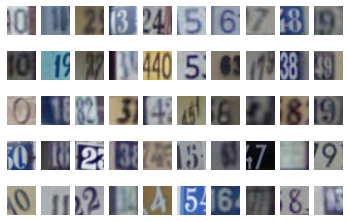

In [ ]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## Задача бинарной классификации

Сначала реализуем KNN для бинарной классификации. В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [ ]:
# First, let's prepare the labels and raw data

# We select only the classes corresponding to digits 0 and 9
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to a one-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

Ниже представлен класс `KNN` для бинарной и многоклассовой классификации

In [ ]:
class KNN:
    """
    K-neariest-neighbor classifier using L1 loss
    """

    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X, num_loops=0):
        '''
        Uses the KNN model to predict classes for the given data samples
        
        Arguments:
        X, np array (num_samples, num_features) - samples to be processed by the model
        num_loops, int - specifies the implementation to use.

        Returns:
        predictions, np array of ints (num_samples) - predicted class for each sample
        '''
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        else:
            dists = self.compute_distances_two_loops(X)

        if self.train_y.dtype == np.bool_:
            return self.predict_labels_binary(dists)
        else:
            return self.predict_labels_multiclass(dists)

    def compute_distances_two_loops(self, X):
        '''
        Computes the L1 distance between every sample in X and every training sample
        Implements the simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            for i_train in range(num_train):
                # Filling dists[i_test][i_train]
                dists[i_test][i_train] = np.sum(
                    np.abs(X[i_test] - self.train_X[i_train])
                    )
        return dists

    def compute_distances_one_loop(self, X):
        '''
        This function computes the L1 distance from every sample in X to every training sample 
        Some of the calculations are vectorized, so only one loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples): array 
            with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            # Filling the whole row of dists[i_test]
            # without additional loops or list comprehensions
            dists[i_test] = np.sum(
                np.abs(X[i_test] - self.train_X),
                axis=1
                )
        return dists
            
    def compute_distances_no_loops(self, X):
        '''
        Computes L1 distance from each sample in X to each training sample
        The calculations are fully vectorized using NumPy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array 
            with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        # Using float32 to save memory - the default is float64
        dists = np.zeros((num_test, num_train), np.float32)
        # Improving distance computation without using loops!
        dists = np.sum(
            np.abs(X[:, np.newaxis, :] - self.train_X),
            axis = 2
            )
        return dists

    def predict_labels_binary(self, dists, predict_type=np.bool_):
        '''
        Returns model predictions for binary classification
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for each test sample
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, predict_type)
        for i in range(num_test):
            # Implementing selection of the best class based on k
            # nearest training samples
            dists_sorted = dists[i].argsort()[:self.k]
            values, counts = np.unique(
                self.train_y[dists_sorted], 
                return_counts=True
                )
            pred[i] = np.min(values[counts == np.max(counts)])
        return pred
            
    def predict_labels_multiclass(self, dists):
        '''
        Returns the model predictions for multi-class classification
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of int (num_test_samples) - predicted class index  
           for each test sample
        '''
        # Implementing the selection of the best class based on the k
        # nearest training samples
        return self.predict_labels_binary(dists, predict_type=np.int_) 

Создаем классификатор и вызываем .fit() для тренировки модели. KNN просто запоминает все данные:

In [ ]:
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

Последовательно реализуем функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в классе `KNN`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание.** Мы будем использовать в качестве расстояния **меру L1** (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

In [ ]:
# Implementing the compute_distances_two_loops method of the KNN class
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# Implementing the compute_distances_one_loop method in the KNN class
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# Implementing the compute_distances_no_loops method of the KNN class
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# Let us observe the difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

20.4 ms ± 711 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.9 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.3 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод `predict_labels_binary` класса KNN:

In [ ]:
prediction = knn_classifier.predict(binary_test_X)

Реализуем функцию `binary_classification_metrics`:

In [ ]:
def binary_classification_metrics(prediction, ground_truth):
    '''
    Computes metrics for binary classification

    Arguments:
    prediction, np array of bool (num_samples) - model predictions
    ground_truth, np array of bool (num_samples) - true labels

    Returns:
    precision, recall, f1, accuracy - classification metrics

    Ref.:
    https://en.wikipedia.org/wiki/Precision_and_recall
    https://en.wikipedia.org/wiki/F1_score
    '''
    # Extract the different classes
    classes = np.unique(ground_truth)

    # Initialize the confusion matrix
    confusion_matrix = np.zeros((classes.size, classes.size))   

    # Loop across the different combinations of actual / predicted classes
    for ix, iy in np.ndindex(confusion_matrix.shape):
      # Count the number of instances in each
      # combination of actual and predicted classes
      confusion_matrix[ix, iy] = np.sum(
          (ground_truth == classes[ix]) & (prediction == classes[iy])
          )

    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[1, 0]
    FN = confusion_matrix[0, 1]

    # Implementing metrics   
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = (2 * (precision * recall) / (precision + recall))
    
    return precision, recall, f1, accuracy

Посмотрим на метрики нашей модели:

In [ ]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)

print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, f1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, f1: 0.70


Создадим экземпляр класса KNN с $k=3$ и посчитаем метрики:

In [ ]:
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)

print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, F1: 0.70


## Кросс-валидация (cross-validation)

Найдем лучшее значение параметра k для алгоритма KNN. 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

In [ ]:
# Find the best k using cross-validation based on the F1 score
num_folds = 5
k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]

k_to_dict = {}
k_to_f1 = {}  # Dictionary mapping k values to mean F1-scores (int -> float)

# Splitting the data into 5 folds: train_folds_X / train_folds_y
train_folds_X = np.array_split(binary_train_X, num_folds)
train_folds_y = np.array_split(binary_train_y, num_folds)

# Performing cross-validation
for k in k_choices:
  # Go through each fold and use it for testing,
  # and all the other folds for validation
  for fold in range(num_folds): 
    # Creating validation and temporary training datasets
    validation_X_test, validation_y_test = train_folds_X[fold], train_folds_y[fold]
    temp_X_train = np.concatenate(train_folds_X[:fold] + train_folds_X[fold + 1:])
    temp_y_train = np.concatenate(train_folds_y[:fold] + train_folds_y[fold + 1:])

    # Initializing a class
    knn_classifier = KNN(k=k)
    knn_classifier.fit(temp_X_train, temp_y_train)

    # Computing the distance
    temp_dists = knn_classifier.compute_distances_two_loops(validation_X_test)
    temp_y_test_pred = knn_classifier.predict_labels_binary(temp_dists)
      
    # Calculating the F-score
    precision, recall, f1, accuracy = binary_classification_metrics(
        temp_y_test_pred, 
        validation_y_test
        )
            
    k_to_dict[k] = k_to_f1.get(k,[]) + [f1]

# Average F1 from all the folds and write it into k_to_f1
for k, values in k_to_dict.items():
  k_to_f1[k] = np.mean(values)

# Check
for k, values in sorted(k_to_f1.items()):
  print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.785714
k = 2, f1 = 0.315789
k = 3, f1 = 0.787879
k = 5, f1 = 0.750000
k = 8, f1 = 0.645161
k = 10, f1 = 0.727273
k = 15, f1 = 0.742857
k = 20, f1 = 0.787879
k = 25, f1 = 0.705882
k = 50, f1 = 0.571429


Построим график

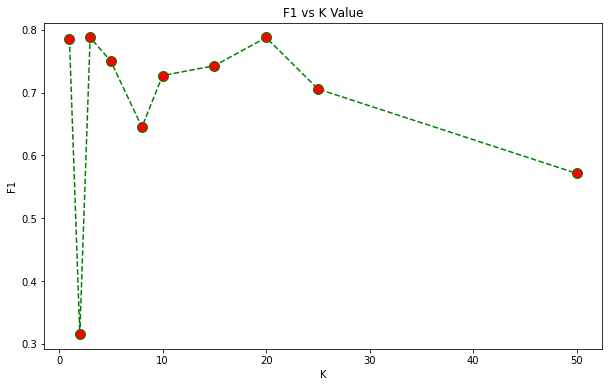

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    list(k_to_f1.keys()), 
    list(k_to_f1.values()),
    color='green',
    linestyle='dashed',
    marker='o',
    markerfacecolor='red',
    markersize=10
)
plt.title('F1 vs K Value')
plt.xlabel('K')
plt.ylabel('F1');

Проверим, как хорошо работает лучшее значение *k* на тестовых данных (test data)

In [ ]:
# Set the best_k to the best value found by cross-validation
best_k = max(k_to_f1, key=k_to_f1.get)

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 3
Accuracy: 0.56, Precision: 0.67, Recall: 0.73, F1: 0.70


## Многоклассовая классификация

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

Реализуем метод `predict_labels_multiclass` класса `KNN`:

In [ ]:
predict = knn_classifier.predict(test_X)

Реализуем функцию `multiclass_accuracy`:

In [ ]:
def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification

    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels

    Returns:
    accuracy - ratio of accurate predictions to total samples
    '''
    # Implementing computing accuracy
    TP = np.mean(ground_truth == prediction)

    return TP

In [ ]:
accuracy = multiclass_accuracy(predict, test_y)

print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Для проведения оценки качества модели мы используем кросс-валидацию. В данном случае нашей основной метрикой является точность (accuracy), которую мы будем усреднять по всем фолдам.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5

# K-fold accuracy scores
k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]

k_to_dict = {}
k_to_accuracy = {}

# Split the training data in 5 folds and store them 
# in train_folds_X / train_folds_y
train_folds_X = np.array_split(train_X, num_folds)
train_folds_y = np.array_split(train_y, num_folds)

# Perform cross-validation
for k in k_choices:
    for fold in range(num_folds):
        # Creating validation data and temp training data
        validation_X_test = train_folds_X[fold]
        validation_y_test = train_folds_y[fold]
        temp_X_train = np.concatenate(train_folds_X[:fold] + train_folds_X[fold + 1:])
        temp_y_train = np.concatenate(train_folds_y[:fold] + train_folds_y[fold + 1:])

        # Initializing a class
        knn_classifier = KNN(k=k)
        knn_classifier.fit(temp_X_train, temp_y_train)

        # Computing the distance
        temp_dists = knn_classifier.compute_distances_two_loops(validation_X_test)
        temp_y_test_pred = knn_classifier.predict_labels_multiclass(temp_dists)

        # Computing the accuracy
        accuracy = multiclass_accuracy(temp_y_test_pred, validation_y_test)

        # Insert the result into the k_to_dict dictionary
        k_to_dict[k] = k_to_accuracy.get(k, []) + [accuracy]

# Average accuracy from all the folds
for k, values in k_to_dict.items():
  k_to_accuracy[k] = np.mean(values)

# Check
for k, values in sorted(k_to_accuracy.items()):
  print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.280000
k = 2, accuracy = 0.230000
k = 3, accuracy = 0.215000
k = 5, accuracy = 0.250000
k = 8, accuracy = 0.245000
k = 10, accuracy = 0.220000
k = 15, accuracy = 0.225000
k = 20, accuracy = 0.200000
k = 25, accuracy = 0.215000
k = 50, accuracy = 0.190000


Построим график

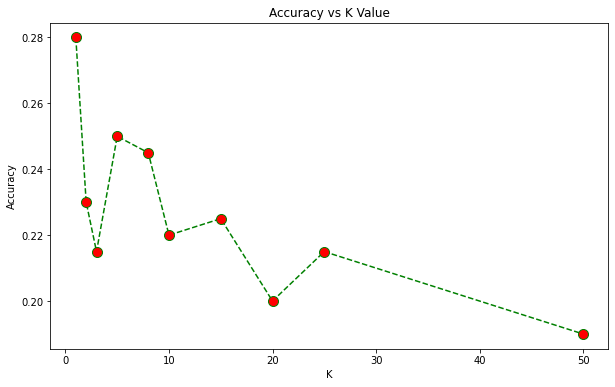

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    list(k_to_accuracy.keys()),
    list(k_to_accuracy.values()),
    color='green', 
    linestyle='dashed',
    marker='o',
    markerfacecolor='red',
    markersize=10
    )
plt.title('Accuracy vs K Value')
plt.xlabel('K')
plt.ylabel('Accuracy');

Для финальной проверки нашей модели мы будем использовать тестовую выборку (test data) для классификации на 10 классов. Мы оценим точность (accuracy) нашей модели, и если все реализовано правильно, ожидаемая точность не должна быть менее **0.2**.

In [ ]:
# Seting the best_k as a best from computed
best_k = max(k_to_accuracy, key=k_to_accuracy.get)

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


# Часть 2. Sklearn

Выполним следующие шаги для многоклассовой классификации с помощью библиотеки `sklearn`:

In [ ]:
# Importing necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

# Training a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors = 1)
knn_classifier.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# The predict method for multi-class classification
predict = knn_classifier.predict(test_X) 

In [ ]:
# Accuracy on X_test
accuracy = accuracy_score(predict, test_y)

print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.20


Кросс-валидация с использованием метрики точности (accuracy) в качестве основной

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5

# K-fold accuracy scores
k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]

k_to_dict = {}
k_to_accuracy = {}

for k in iter(k_choices):
  classifier = KNeighborsClassifier(n_neighbors = k)
  accuracy = cross_val_score(
      classifier, 
      train_X, 
      train_y, 
      cv=num_folds, 
      scoring='accuracy'
      )
  # Appending values for k neighbors to the k_to_dict dictionary
  k_to_dict[k] = k_to_dict.get(k,[]) + [accuracy]

# Average accuracy from all the folds
for k, values in k_to_dict.items():
  k_to_accuracy[k] = np.mean(values)

# Check
for k, values in sorted(k_to_accuracy.items()):
  print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.245000
k = 2, accuracy = 0.249000
k = 3, accuracy = 0.260000
k = 5, accuracy = 0.258000
k = 8, accuracy = 0.251000
k = 10, accuracy = 0.238000
k = 15, accuracy = 0.239000
k = 20, accuracy = 0.228000
k = 25, accuracy = 0.227000
k = 50, accuracy = 0.225000


Построим график

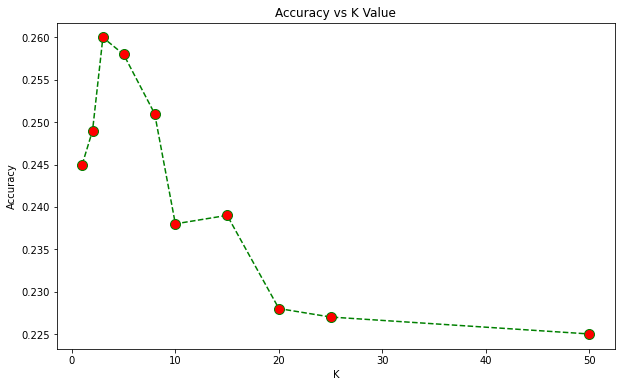

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    list(k_to_accuracy.keys()), 
    list(k_to_accuracy.values()), 
    color='green', 
    linestyle='dashed', 
    marker='o', 
    markerfacecolor='red', 
    markersize=10
    )
plt.title('Accuracy vs K Value')
plt.xlabel('K')
plt.ylabel('Accuracy');

In [ ]:
# Seting the best_k as a best from computed
best_k = max(k_to_accuracy, key=k_to_accuracy.get)

best_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = accuracy_score(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.25
